In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [7]:
img = cv2.imread('original_img.jpg')
if img is None:
    print("Error: Image not found or could not be loaded.")
else:
    # Convert the image from BGR to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
# Pixels is a 2D array with a shape of (total_number_of_pixels, 3)
# Each row represents a pixel the 3 columns contain the RGB values
pixels = img.reshape((-1, 3)).astype(np.float32)


Image Compression with K-Means Clustering

Identifies the k most representative colors and replaces the RGB value of all pixels to match one of those colors.

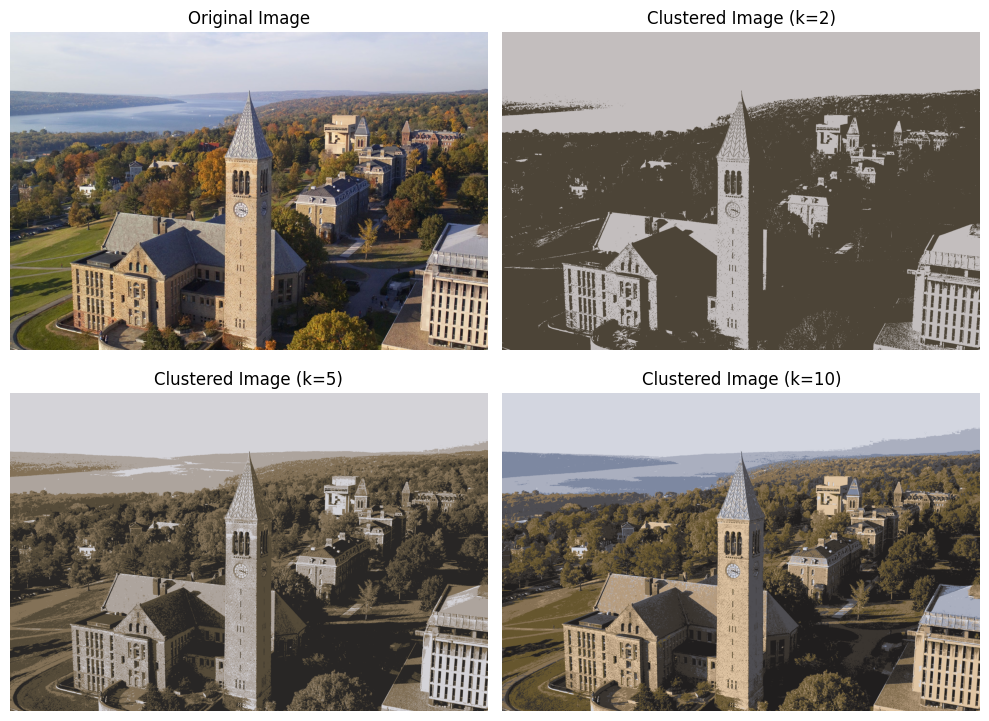

In [8]:
# This cell displays the original image and 3 clustered images in a 2x2 grid

plt.figure(figsize=(10, 7.5))

plt.subplot(2, 2, 1)  # (rows, cols, position)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

k_values = [2, 5, 10]
for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, n_init=5, random_state=42)
    kmeans.fit(pixels)

    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    clustered_img = cluster_centers[labels].reshape(img.shape).astype(np.uint8)


    plt.subplot(2, 2, i + 2) 
    plt.imshow(clustered_img)
    plt.title(f"Clustered Image (k={k})")
    plt.axis('off')

plt.tight_layout()
plt.show()

Edge Detection with Sobel Filters

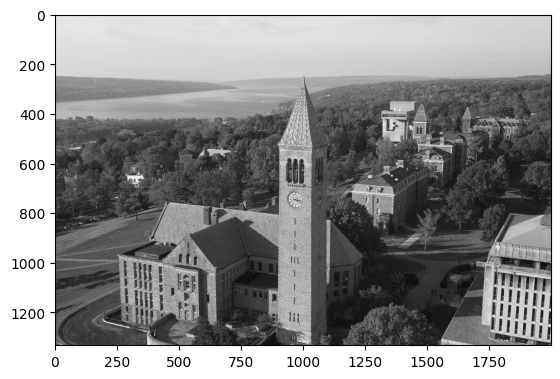

In [9]:
img = cv2.imread('original_img.jpg')
# grayscale image to prepare for edge detection
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)   
plt.imshow(gray_img,cmap='gray')              

In [10]:
def sobel_filters(img):
    PAD_SIZE = 1 #Kernel is 3 x 3, so the pad_size is 1
    img = np.pad(img, PAD_SIZE) #Pad image, so we take a kernel mask of the borders

    Kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) #Detect edges in x direction
    Ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) #Detect edges in y direction

    row, col = img.shape

    output_img = np.zeros((row - 2 * PAD_SIZE, col - 2 * PAD_SIZE)) #Output image should be the orignal image size without padding


    for i in range(PAD_SIZE, row - PAD_SIZE):
        for j in range(PAD_SIZE, col - PAD_SIZE):
            kernel = img[i - PAD_SIZE:i + PAD_SIZE + 1, j - PAD_SIZE:j + PAD_SIZE + 1]
            Ix = np.sum(kernel * Kx)
            Iy = np.sum(kernel * Ky)
            G = np.hypot(Ix,Iy) #Combine our detection in the x and y directions by finding the square root of the sum of the squares 
            output_img[i - PAD_SIZE, j - PAD_SIZE] = G
    return output_img

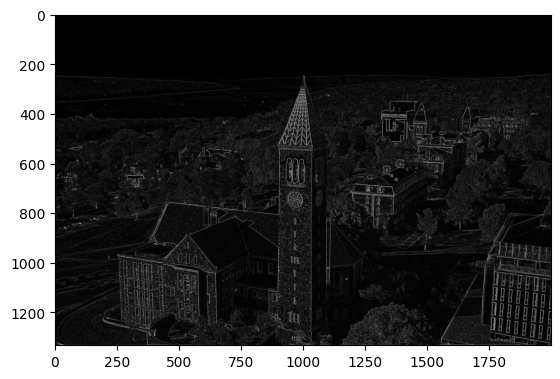

In [14]:
edge_dectected = sobel_filters(gray_img)
plt.imshow(edge_dectected, cmap='gray')
plt.imsave('edge_detected_img.png', edge_dectected, cmap='gray')